# Nanoclusters

THE GENERAL CONCEPT:

I want to generate an algorithm to generate nanoparticles randomly/heuristically. I was thinking of using a grid method and this workflow. There are different iterations to this method. I will input them one by one, so I can test them. Each iteration builds from the previous ones.

POINT GENERATION
First iteration

- generate a cubic 3D grid that has a cube in the center (odd number of spacings)
- place an atom in the a the center of the central cube, but at a random position within the smaller cube 
- then remove the site where I placed the first atom from the list of possible sites (cubes)
- I need some sort of adjacency matrix because I want to know the sites that are near the occupied ones. Can I generate this once at the beginning and update it by removing the sites that have been occupied?
- create a list of the indices of the cubes that are nn to the one that i just occupied. 
- add a new atom in in one of the cubes that are nn (random) and give a coordinate that is random inside that cube
- remove this site from the possible ones for atom 3
- add atom 2 nn as possible sites for the atom 3 (ensure there are no duplicates)
- ...
- here I only care that when I add a new atom, it is neighbour of one of the other sites. This way I am not necessarily forming compact nanoclusters

Second iteration
- now I have two atom types. When I place a new atom, I want to ensure that it is at least next to one of the sites containing one of the other atom types.

Third iteration:
- now I want to select the site that has the largest number of sites with the other atom type next to it. DOes this lead to compact nanoclusters?

Fourth iteration:
- instead of using a lattice grid, generate a set of random points ensuring that they are not closer than a threshold distance.
- build the voronoi polyhedra for the points
- build some sort of adjacency matrix, althought it won't be a matrix because each sites will have a different number of neighbours, maybe a dictionary?
- use the appraoch of the second iteration
- use the approach of the third iteration


COMBINATORIAL ANALYSIS

I want to use the points I generated above as the starting point and, for example occupy sites A with two different atom types. Let's start with a fixed 50% concentration
- Write a simulated annealing code that takes the points above and changes the occupations of the sites, relaxing the geometry using mace (e.g.):
def compute_energy(struct):
        optimized_structure = GeomOpt(
        struct=struct.copy(),
        arch="mace_mp",
        device="cuda", #check this
        model_path="/work/e05/e05/bcamino/mace/fine_tuning/test_ft_model/1000/AlGaN-medium-mpa-0.model",
        calc_kwargs={"default_dtype": "float64"},
        fmax=0.001,
        filter_kwargs={"hydrostatic_strain": True},
                )
        
        optimized_structure.run()

        return optimized_structure.struct, optimized_structure.struct.get_potential_energy()
- write a genetic algorithm code that does the same thing. Can each cluster with a number of points be a the beginning of a "family"?


INTERMEDIATE SIZE
- Instead of a cubic grid of points, use lattice positions that are read from a bulk, so generate supercell. Place the first atom in the center and then occupy neighbouring sites to have a compact structure

LARGE SIZE
- Build the core of the bulk-like NP using BCN (NP0).
- Add/remove atoms on the surface to have a stoichiometric NP 
- Vary the occupancy of the sites that are left to obtain the concetration of interest



In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from ase.io import read, write
from ase.data import chemical_symbols
from ase.atoms import Atoms
import copy
import numpy as np
import pandas as pd
from scipy.constants import physical_constants
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from scipy.stats import spearmanr, kendalltau

import matplotlib.pyplot as plt

import sys
import os
import json
import re
import shutil as sh

from janus_core.calculations.single_point import SinglePoint
from janus_core.calculations.geom_opt import GeomOpt

from ase.visualize import view
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

current_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(current_dir)

import random
from scipy.spatial import Voronoi, distance_matrix

from structure_generation import get_all_configurations_pmg, write_extended_xyz, generate_random_structures, \
    write_CRYSTAL_gui_from_data

from local_functions import lattice_params_to_matrix, get_errors, get_rankings

#### First iteration

In [3]:
import numpy as np
import random

def generate_grid(grid_size, cube_length):
    assert grid_size % 2 == 1, "Grid size must be odd"
    half = grid_size // 2

    grid_indices = [(i, j, k) 
                    for i in range(-half, half + 1)
                    for j in range(-half, half + 1)
                    for k in range(-half, half + 1)]

    nn_map = {}
    for i, j, k in grid_indices:
        neighbors = []
        for di, dj, dk in [(-1, 0, 0), (1, 0, 0),
                           (0, -1, 0), (0, 1, 0),
                           (0, 0, -1), (0, 0, 1)]:
            ni, nj, nk = i + di, j + dj, k + dk
            if (-half <= ni <= half and
                -half <= nj <= half and
                -half <= nk <= half):
                neighbors.append((ni, nj, nk))
        nn_map[(i, j, k)] = neighbors
 
    return grid_indices, nn_map

def random_position_in_cube(i, j, k, cube_length, shift=0):
    origin = np.array([i + shift, j + shift, k + shift]) * cube_length
    return origin + np.random.rand(3) * cube_length

def generate_nanoparticle(grid_size=5, cube_length=1.0, num_atoms=10):
    grid_indices, nn_map = generate_grid(grid_size, cube_length)

    center = (grid_size // 2, grid_size // 2, grid_size // 2)
    occupied = set()
    available = set([center])
    atom_positions = []

    for _ in range(num_atoms):
        if not available:
            print("No more available positions!")
            break
        chosen_site = random.choice(list(available))
        pos = random_position_in_cube(*chosen_site, cube_length)
        atom_positions.append(pos)
        occupied.add(chosen_site)
        available.remove(chosen_site)

        # Add new neighbors to available set
        for nn in nn_map[chosen_site]:
            if nn not in occupied:
                available.add(nn)

    return np.array(atom_positions)

In [4]:
cube_length = 1 # size of each cube withing the larger cube. Useful to define the minimum distance
num_atoms = 10
grid_size = 3
np_coords = generate_nanoparticle(grid_size=grid_size, cube_length=cube_length, num_atoms=num_atoms)
vview(Structure(np.eye(3)*cube_length*grid_size,[1]*num_atoms,np_coords,coords_are_cartesian=True))

#### Second iteration

In [5]:
def generate_nanoparticle_mixed(grid_size=11, cube_length=1.0, num_atoms=10, atom_type_pair=('A', 'B')):
    
    grid_indices, nn_map = generate_grid(grid_size, cube_length)
    half = grid_size // 2

    center = (0, 0, 0)
    atom_positions = []
    atom_types = []  # list of atom type strings
    occupied = {}    # maps cube index to atom type
    available = set()

    # --- Place the first atom (center) ---
    first_type = atom_type_pair[0]
    second_type = atom_type_pair[1]

    first_pos = random_position_in_cube(*center, cube_length, shift=half)
    atom_positions.append(first_pos)
    atom_types.append(first_type)
    occupied[center] = first_type

    # Add neighbors of the center to the available set
    for nn in nn_map[center]:
        available.add(nn)

    current_type = second_type  # alternate from the first type

    for _ in range(1, num_atoms):
        valid_candidates = []
        for site in available:
            neighbors = nn_map[site]
            if any((n in occupied and occupied[n] != current_type) for n in neighbors):
                valid_candidates.append(site)

        if not valid_candidates:
            print("No valid placement found with current rules.")
            break

        chosen_site = random.choice(valid_candidates)
        pos = random_position_in_cube(*chosen_site, cube_length, shift=half)
        atom_positions.append(pos)
        atom_types.append(current_type)

        occupied[chosen_site] = current_type
        available.remove(chosen_site)

        for nn in nn_map[chosen_site]:
            if nn not in occupied:
                available.add(nn)

        # Alternate atom type
        current_type = first_type if current_type == second_type else second_type

    return np.array(atom_positions), atom_types

In [99]:
cube_length = 2. # size of each cube withing the larger cube. Useful to define the minimum distance
num_atoms = 10
grid_size = 5
np_coords, atom_types = generate_nanoparticle_mixed(grid_size=grid_size, cube_length=cube_length, num_atoms=num_atoms,atom_type_pair=('Mg', 'O'))
vview(Structure(np.eye(3)*cube_length*grid_size,atom_types,np_coords,coords_are_cartesian=True))

In [6]:
def create_np_in_box(atom_types, positions, box_size=20.0):
    """
    Create a centered nanoparticle inside a cubic box.

    Parameters:
    - atom_types: list of strings, e.g. ['Al', 'Ga', 'Al', ...]
    - positions: np.ndarray of shape (N, 3)
    - box_size: float, length of the cubic cell

    Returns:
    - ASE Atoms object with centered positions and box
    """
    atoms = Atoms(atom_types, positions=positions)

    # Shift atoms to center the structure in the box
    center_of_box = np.array([box_size / 2.0] * 3)
    current_center = atoms.get_center_of_mass()
    shift_vector = center_of_box - current_center
    atoms.translate(shift_vector)

    # Define the cell and turn off periodic boundary conditions
    atoms.set_cell([box_size, box_size, box_size])
    atoms.set_pbc(False)

    return atoms

In [16]:
all_nps = []
num_atoms = 6
for i in range(500):
    np_coords, atom_types = generate_nanoparticle_mixed(
                                                        grid_size=grid_size, cube_length=cube_length, 
                                                        num_atoms=num_atoms,atom_type_pair=('Mg', 'O'))
    atoms = create_np_in_box(atom_types, np_coords, box_size=20.0)
    all_nps.append(atoms)

In [20]:
view(all_nps[340])

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/mace-tes...>

In [ ]:
from ase import Atoms
from ase.geometry import geometry
from scipy.spatial.distance import pdist, squareform
import numpy as np

def rescale_structure_to_min_bond(structure, target_min_dist):
    """
    Scales all atomic positions so that the minimum interatomic distance
    equals target_min_dist.
    """
    positions = structure.get_positions()
    dist_matrix = squareform(pdist(positions))
    np.fill_diagonal(dist_matrix, np.inf)
    min_dist = dist_matrix.min()

    if min_dist < 1e-5:
        raise ValueError("Structure contains overlapping atoms.")

    scale_factor = target_min_dist / min_dist
    new_positions = positions * scale_factor
    structure.set_positions(new_positions)

    # Optional: scale cell too if you're preserving box
    cell = structure.get_cell()
    if np.any(cell):  # nonzero cell
        structure.set_cell(cell * scale_factor)

    return structure

In [17]:
def write_all_nps(output_file, all_nps):

    write(output_file, all_nps)

write_all_nps('data/nanoclusters/np_6.xyz', all_nps)

In [36]:
structures = read("data/nanoclusters/np_opt.xyz", index=":")

In [45]:
view(structures[4])

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/mace-tes...>

In [44]:
for i in range(len(structures)):
    print(structures[i].info['mace_mp_energy'])

-16.017185623001357
-16.017185637231563
-16.01718560648658
-16.01718564242558
-14.67985791763321
-14.679857908545513
-16.0171855874781
-16.017185649386615
-14.46178363195848
60.5180187650315
-14.67985792162018
-16.017185650473344
-16.017185655801736
-16.0171855313147
-16.01718565251818
-16.017185650137932
-14.461783602513043
-16.017185645511038
-16.017185642129437
-14.46178155752774
-16.01718565755461
-16.017185633187665
-16.017185658357025
-16.01718565759313
-16.017185654062725
-16.017185653253293
-16.01718563124982
-16.0171856238922
-16.017185638610226
-14.46178365598882
-16.017185633065065
-16.017185646722666
-16.017185617077374
-16.017185641942252
-16.0171856459718
-14.461783642405097
-14.461783663471579
-14.461783613507377
-14.679857930907415
-16.017185633054194
-16.01718558149098
-14.46178364629975
-16.017185658864616
-16.017185620805797
-14.679857877465354
-16.017185643091377
-14.679857865305873
-16.01718563910576
-16.017185531274123
-16.017185652542345


In [ ]:
import numpy as np
from ase.io import read
from scipy.spatial.distance import pdist, squareform


def compute_binding_energy(cluster_energy, atom_energies):
    """Compute binding energy per atom"""
    total_atom_energy = sum(atom_energies)
    n_atoms = len(atom_energies)
    return (total_atom_energy - cluster_energy) / n_atoms


def compute_radius_of_gyration(positions):
    """Compute radius of gyration"""
    com = positions.mean(axis=0)
    squared_distances = np.sum((positions - com) ** 2, axis=1)
    return np.sqrt(np.mean(squared_distances))


def compute_min_distance(positions):
    """Compute the minimum interatomic distance"""
    dist_matrix = squareform(pdist(positions))
    np.fill_diagonal(dist_matrix, np.inf)
    return np.min(dist_matrix)


# === Load your nanoparticle structure ===
structure = read("np_opt.xyz", index=0)  # or loop over index=':'
positions = structure.get_positions()

# Extract total energy (assumes stored in .info)
cluster_energy = structure.info.get("mace_energy")

# For demo: assume reference atom energy is from the first atom repeated
# Replace this with proper isolated atom energies if you have them
atom_energy = structure[0].get_potential_energy()  # Placeholder
atom_energies = [atom_energy] * len(structure)

# Compute metrics
binding_energy = compute_binding_energy(cluster_energy, atom_energies)
rg = compute_radius_of_gyration(positions)
min_dist = compute_min_distance(positions)

# Print results
print("Nanocluster Metrics")
print(f"→ Binding energy per atom:     {binding_energy:.6f} eV")
print(f"→ Radius of gyration:          {rg:.3f} Å")
print(f"→ Min interatomic distance:    {min_dist:.3f} Å")

### Third iteration

In [66]:
def generate_nanoparticle_mixed_dense(grid_size=11, cube_length=1.0, num_atoms=10, atom_type_pair=('A', 'B')):
    grid_indices, nn_map = generate_grid(grid_size, cube_length)
    half = grid_size // 2

    center = (0, 0, 0)
    atom_positions = []
    atom_types = []  # list of atom type strings
    occupied = {}    # maps cube index to atom type
    available = set()

    # --- Place the first atom (center) ---
    first_type = atom_type_pair[0]
    second_type = atom_type_pair[1]

    first_pos = random_position_in_cube(*center, cube_length, shift=half)
    atom_positions.append(first_pos)
    atom_types.append(first_type)
    occupied[center] = first_type

    # Add neighbors of the center to the available set
    for nn in nn_map[center]:
        available.add(nn)

    current_type = second_type  # alternate from the first type

    for _ in range(1, num_atoms):
        best_score = -1
        best_candidates = []

        for site in available:
            neighbors = nn_map[site]
            score = sum(1 for n in neighbors if n in occupied and occupied[n] != current_type)
            if score > best_score:
                best_score = score
                best_candidates = [site]
            elif score == best_score:
                best_candidates.append(site)

        if not best_candidates:
            print("No valid placement found with current rules.")
            break

        chosen_site = random.choice(best_candidates)
        pos = random_position_in_cube(*chosen_site, cube_length, shift=half)
        atom_positions.append(pos)
        atom_types.append(current_type)

        occupied[chosen_site] = current_type
        available.remove(chosen_site)

        for nn in nn_map[chosen_site]:
            if nn not in occupied:
                available.add(nn)

        # Alternate atom type
        current_type = first_type if current_type == second_type else second_type

    return np.array(atom_positions), atom_types

In [71]:
cube_length = 2 # size of each cube withing the larger cube. Useful to define the minimum distance
num_atoms = 6
grid_size = 5
np_coords, atom_types = generate_nanoparticle_mixed_dense(grid_size=grid_size, cube_length=cube_length, num_atoms=num_atoms,atom_type_pair=('Mg', 'O'))
vview(Structure(np.eye(3)*cube_length*grid_size,atom_types,np_coords,coords_are_cartesian=True))

### Fourth iteration

In [73]:
def generate_random_points(num_points, min_distance, box_size):
    points = []
    while len(points) < num_points:
        p = np.random.rand(3) * box_size
        if all(np.linalg.norm(p - np.array(q)) >= min_distance for q in points):
            points.append(p)
    return np.array(points)

In [74]:
def build_voronoi_neighbors(points):
    vor = Voronoi(points)
    neighbor_map = {i: set() for i in range(len(points))}
    for ridge in vor.ridge_points:
        i, j = ridge
        neighbor_map[i].add(j)
        neighbor_map[j].add(i)
    return neighbor_map

In [75]:
def generate_voronoi_nanoparticle(num_points=100,
                                   num_atoms=30,
                                   min_distance=1.0,
                                   box_size=10.0,
                                   atom_type_pair=('A', 'B')):

    points = generate_random_points(num_points, min_distance, box_size)
    neighbor_map = build_voronoi_neighbors(points)

    atom_positions = []
    atom_types = []
    occupied = {}
    available = set()

    # Start with a random site
    start_index = random.randint(0, num_points - 1)
    type_a, type_b = atom_type_pair
    current_type = type_a

    atom_positions.append(points[start_index])
    atom_types.append(current_type)
    occupied[start_index] = current_type

    for n in neighbor_map[start_index]:
        available.add(n)

    current_type = type_b  # Alternate

    for _ in range(1, num_atoms):
        best_score = -1
        best_candidates = []

        for site in available:
            neighbors = neighbor_map[site]
            score = sum(1 for n in neighbors if n in occupied and occupied[n] != current_type)

            if score > best_score:
                best_score = score
                best_candidates = [site]
            elif score == best_score:
                best_candidates.append(site)

        if not best_candidates:
            print("No valid site found with current rules.")
            break

        chosen = random.choice(best_candidates)
        atom_positions.append(points[chosen])
        atom_types.append(current_type)
        occupied[chosen] = current_type
        available.remove(chosen)

        for nn in neighbor_map[chosen]:
            if nn not in occupied:
                available.add(nn)

        current_type = type_a if current_type == type_b else type_b

    return np.array(atom_positions), atom_types

In [79]:
np_coords, atom_types = generate_voronoi_nanoparticle(
    num_points=100,
    num_atoms=6,
    min_distance=1.5,
    box_size=15,
    atom_type_pair=('Mg', 'O')
)
vview(Structure(np.eye(3)*cube_length*grid_size,atom_types,np_coords,coords_are_cartesian=True))

#### Visualise grid

In [92]:
def visualize_all_points_with_neighbors(points, neighbor_map):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot all points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='gray', s=20)

    # Draw lines between Voronoi neighbors
    for i, neighbors in neighbor_map.items():
        for j in neighbors:
            if i < j:
                x = [points[i][0], points[j][0]]
                y = [points[i][1], points[j][1]]
                z = [points[i][2], points[j][2]]
                ax.plot(x, y, z, color='lightblue', linewidth=0.5)

    ax.set_title("Random Points with Voronoi-Based Neighbors")
    plt.tight_layout()
    plt.show()

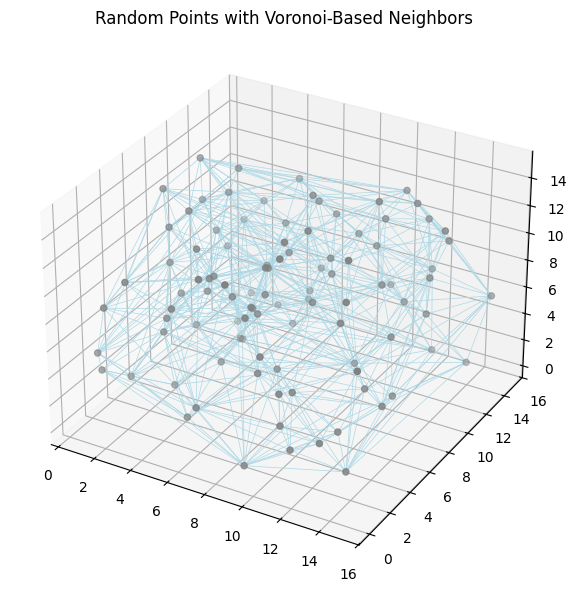

In [93]:
points = generate_random_points(num_points=100, min_distance=1.5, box_size=15)
neighbor_map = build_voronoi_neighbors(points)
visualize_all_points_with_neighbors(points, neighbor_map)

# OLD

In [2]:
import numpy as np
from scipy.spatial.distance import cdist

def generate_grid(N):
    """Generate an NxNxN grid of fractional coordinates."""
    grid = np.mgrid[0:N, 0:N, 0:N] / N  # Normalize to fractional coordinates
    grid_points = np.vstack([grid[0].ravel(), grid[1].ravel(), grid[2].ravel()]).T
    return grid_points

def compute_distance_matrix(grid_points, N):
    """Compute the distance matrix where each entry is the integer distance in grid steps."""
    distances = cdist(grid_points, grid_points, metric='euclidean')
    step_distances = np.round(distances * N).astype(int)  # Convert Euclidean distance to step distance
    return step_distances

# Example usage
N = 4  # Define grid size
grid_points = generate_grid(N)
distance_matrix = compute_distance_matrix(grid_points, N)

# Print results
print("Grid Points:\n", grid_points)
print("\nDistance Matrix:\n", distance_matrix)

Grid Points:
 [[0.   0.   0.  ]
 [0.   0.   0.25]
 [0.   0.   0.5 ]
 [0.   0.   0.75]
 [0.   0.25 0.  ]
 [0.   0.25 0.25]
 [0.   0.25 0.5 ]
 [0.   0.25 0.75]
 [0.   0.5  0.  ]
 [0.   0.5  0.25]
 [0.   0.5  0.5 ]
 [0.   0.5  0.75]
 [0.   0.75 0.  ]
 [0.   0.75 0.25]
 [0.   0.75 0.5 ]
 [0.   0.75 0.75]
 [0.25 0.   0.  ]
 [0.25 0.   0.25]
 [0.25 0.   0.5 ]
 [0.25 0.   0.75]
 [0.25 0.25 0.  ]
 [0.25 0.25 0.25]
 [0.25 0.25 0.5 ]
 [0.25 0.25 0.75]
 [0.25 0.5  0.  ]
 [0.25 0.5  0.25]
 [0.25 0.5  0.5 ]
 [0.25 0.5  0.75]
 [0.25 0.75 0.  ]
 [0.25 0.75 0.25]
 [0.25 0.75 0.5 ]
 [0.25 0.75 0.75]
 [0.5  0.   0.  ]
 [0.5  0.   0.25]
 [0.5  0.   0.5 ]
 [0.5  0.   0.75]
 [0.5  0.25 0.  ]
 [0.5  0.25 0.25]
 [0.5  0.25 0.5 ]
 [0.5  0.25 0.75]
 [0.5  0.5  0.  ]
 [0.5  0.5  0.25]
 [0.5  0.5  0.5 ]
 [0.5  0.5  0.75]
 [0.5  0.75 0.  ]
 [0.5  0.75 0.25]
 [0.5  0.75 0.5 ]
 [0.5  0.75 0.75]
 [0.75 0.   0.  ]
 [0.75 0.   0.25]
 [0.75 0.   0.5 ]
 [0.75 0.   0.75]
 [0.75 0.25 0.  ]
 [0.75 0.25 0.25]
 [0.75 0.25 0.

### Initial code

In [3]:
import numpy as np
import random
from scipy.spatial.distance import cdist

def generate_grid(N):
    """Generate an NxNxN grid of fractional coordinates."""
    grid = np.mgrid[0:N, 0:N, 0:N] / N  # Normalize to fractional coordinates
    grid_points = np.vstack([grid[0].ravel(), grid[1].ravel(), grid[2].ravel()]).T
    return grid_points

def compute_distance_matrix(grid_points):
    """Compute the distance matrix where each entry is the integer distance in grid steps."""
    distances = cdist(grid_points, grid_points, metric='euclidean')
    step_distances = np.round(distances * N).astype(int)  # Convert Euclidean distance to step distance
    return step_distances

def get_nearest_neighbors(grid_points, site_index, distance_matrix):
    """Return the indices of nearest neighbor (NN) sites."""
    nn_indices = np.where(distance_matrix[site_index] == 1)[0]  # Distance 1 = NN
    return set(nn_indices)

def generate_nanoparticle(N, num_atoms):
    """Generate a nanoparticle using the heuristic grid method."""
    grid_points = generate_grid(N)  # Get the fractional coordinate grid
    distance_matrix = compute_distance_matrix(grid_points)  # Compute NN relations

    # Start with a random initial site
    available_sites = set(range(len(grid_points)))  # Track available cubes
    selected_atoms = []  # Store atom positions

    first_site = random.choice(list(available_sites))
    first_position = grid_points[first_site] + np.random.uniform(0, 1/N, size=3)  # Random inside cube
    selected_atoms.append(first_position)
    available_sites.remove(first_site)

    # Initialize the set of candidate sites
    candidate_sites = get_nearest_neighbors(grid_points, first_site, distance_matrix)
    candidate_sites -= {first_site}  # Remove already occupied

    # Grow the nanoparticle
    for _ in range(num_atoms - 1):
        if not candidate_sites:
            break  # No more NN available

        # Choose a new site from candidates
        new_site = random.choice(list(candidate_sites))
        new_position = grid_points[new_site] + np.random.uniform(0, 1/N, size=3)  # Random inside cube

        # Store new atom
        selected_atoms.append(new_position)

        # Only remove from available sites if it exists (avoid KeyError)
        if new_site in available_sites:
            available_sites.remove(new_site)

        # Update candidate sites
        new_nn = get_nearest_neighbors(grid_points, new_site, distance_matrix)
        candidate_sites.update(new_nn)
        candidate_sites -= available_sites  # Avoid duplicates
        candidate_sites -= {new_site}  # Don't reselect

    return np.array(selected_atoms)

# Parameters
N = 4  # Grid size
num_atoms = 10  # Number of atoms to place

# Generate nanoparticle
nanoparticle_atoms = generate_nanoparticle(N, num_atoms)

# Display generated atom positions
import pandas as pd
import ace_tools as tools

df_nanoparticle = pd.DataFrame(nanoparticle_atoms, columns=["x", "y", "z"])
tools.display_dataframe_to_user(name="Nanoparticle Atom Positions", dataframe=df_nanoparticle)

ModuleNotFoundError: No module named 'ace_tools'

## Favour NN

In [ ]:
# Re-import necessary libraries after execution state reset
import numpy as np
import random
import pandas as pd
from scipy.spatial.distance import cdist
import ace_tools as tools

def generate_grid(N):
    """Generate an NxNxN grid of fractional coordinates."""
    grid = np.mgrid[0:N, 0:N, 0:N] / N  # Normalize to fractional coordinates
    grid_points = np.vstack([grid[0].ravel(), grid[1].ravel(), grid[2].ravel()]).T
    return grid_points

def compute_distance_matrix(grid_points):
    """Compute the distance matrix where each entry is the integer distance in grid steps."""
    distances = cdist(grid_points, grid_points, metric='euclidean')
    step_distances = np.round(distances * N).astype(int)  # Convert Euclidean distance to step distance
    return step_distances

def get_nearest_neighbors(grid_points, site_index, distance_matrix):
    """Return the indices of nearest neighbor (NN) sites."""
    nn_indices = np.where(distance_matrix[site_index] == 1)[0]  # Distance 1 = NN
    return set(nn_indices)

def generate_compact_nanoparticle(N, num_atoms):
    """Generate a nanoparticle prioritizing sites with the most occupied neighbors."""
    grid_points = generate_grid(N)  # Get the fractional coordinate grid
    distance_matrix = compute_distance_matrix(grid_points)  # Compute NN relations

    # Start with a random initial site
    available_sites = set(range(len(grid_points)))  # Track available cubes
    selected_atoms = []  # Store atom positions

    first_site = random.choice(list(available_sites))
    first_position = grid_points[first_site] + np.random.uniform(0, 1/N, size=3)  # Random inside cube
    selected_atoms.append(first_position)
    available_sites.remove(first_site)

    # Initialize candidate sites with a priority count (number of occupied neighbors)
    candidate_sites = {}
    for nn in get_nearest_neighbors(grid_points, first_site, distance_matrix):
        candidate_sites[nn] = 1  # Since first site is occupied, NNs now have one occupied neighbor

    # Grow the nanoparticle
    for _ in range(num_atoms - 1):
        if not candidate_sites:
            break  # No more NN available

        # Choose the site with the highest number of occupied neighbors
        new_site = max(candidate_sites, key=candidate_sites.get)
        new_position = grid_points[new_site] + np.random.uniform(0, 1/N, size=3)  # Random inside cube

        # Store new atom
        selected_atoms.append(new_position)

        # Remove from available sites and candidate list
        if new_site in available_sites:
            available_sites.remove(new_site)
        candidate_sites.pop(new_site, None)

        # Update candidate sites by increasing their occupied neighbor count
        for nn in get_nearest_neighbors(grid_points, new_site, distance_matrix):
            if nn in available_sites:  # Only track available sites
                candidate_sites[nn] = candidate_sites.get(nn, 0) + 1

    return np.array(selected_atoms)

# Parameters
N = 4  # Grid size
num_atoms = 10  # Number of atoms to place

# Generate a more compact nanoparticle
compact_nanoparticle_atoms = generate_compact_nanoparticle(N, num_atoms)

# Display generated atom positions
df_compact_nanoparticle = pd.DataFrame(compact_nanoparticle_atoms, columns=["x", "y", "z"])
tools.display_dataframe_to_user(name="Compact Nanoparticle Atom Positions", dataframe=df_compact_nanoparticle)

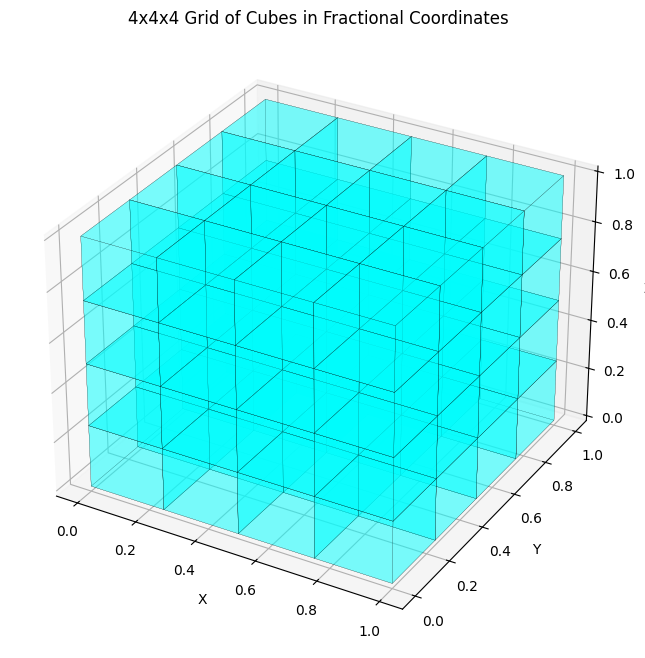

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def generate_grid(N):
    """Generate a NxNxN grid of fractional coordinates."""
    grid = []
    for i in range(N):
        for j in range(N):
            for k in range(N):
                x = i / N
                y = j / N
                z = k / N
                grid.append((x, y, z))
    return grid

def plot_grid(N):
    """Plot the NxNxN grid of cubes in fractional coordinates."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    
    # Generate grid points
    grid = generate_grid(N)
    
    # Define cube vertices
    for x, y, z in grid:
        cube_vertices = np.array([
            [x, y, z],
            [x + 1/N, y, z],
            [x + 1/N, y + 1/N, z],
            [x, y + 1/N, z],
            [x, y, z + 1/N],
            [x + 1/N, y, z + 1/N],
            [x + 1/N, y + 1/N, z + 1/N],
            [x, y + 1/N, z + 1/N]
        ])
        
        # Define cube faces
        faces = [
            [cube_vertices[j] for j in [0, 1, 2, 3]],  # Bottom face
            [cube_vertices[j] for j in [4, 5, 6, 7]],  # Top face
            [cube_vertices[j] for j in [0, 1, 5, 4]],  # Side face
            [cube_vertices[j] for j in [2, 3, 7, 6]],  # Opposite side face
            [cube_vertices[j] for j in [1, 2, 6, 5]],  # Front face
            [cube_vertices[j] for j in [0, 3, 7, 4]],  # Back face
        ]
        
        ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=0.1, edgecolors='black', alpha=0.3))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"{N}x{N}x{N} Grid of Cubes in Fractional Coordinates")
    plt.show()

# Define N and plot the grid
N = 4  # Example: a 4x4x4 grid
plot_grid(N)